In [1]:
import sys
sys.path.append('../../cluster')

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
#own Kmeans
from kmeans_algorithm import Kmeans
#from sklearn.cluster import KMeans

from sqlalchemy import create_engine

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
stringDB = "mysql+pymysql://root:@localhost:3306/cs2013db"
# Conexion a la BD
engine = create_engine(stringDB)

In [3]:
query = "SELECT * FROM k_a where id = 2;"
dfka = pd.read_sql(query, engine)

In [4]:
def vectorizarDocs(docs):
    vectorizer = TfidfVectorizer(stop_words = 'english',#tokenizer = tokenize_and_stem,
                             max_features = 20000)
    vectors = vectorizer.fit_transform(docs)
    feature_names = vectorizer.get_feature_names()
    dense = vectors.todense()
    denselist = dense.tolist()
    dfvec = pd.DataFrame(denselist, columns=feature_names)
    return dfvec

def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    features = tf_idf_array.columns
    tf_idf_array = tf_idf_array.values
    
    labels = np.unique(prediction)
    print(labels)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    
    for d in dfs:
        height = [h[1] for h in d.values]
        bars = [h[0] for h in d.values]
        y_pos = np.arange(len(bars))
        plt.barh(y_pos, height)
        plt.yticks(y_pos, bars)
        plt.show()

def draw_cluster(vectorizer, n_k):
    #Implementación propia
    sklearn_pca = PCA(n_components = 2)
    Y_sklearn = sklearn_pca.fit_transform(vectorizer)
    test_e = Kmeans(n_k, 1, 600)
    fitted = test_e.fit_kmeans(Y_sklearn)
    pre_values = test_e.predict(Y_sklearn)

    plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=pre_values, s=50, cmap='viridis')

    centers = fitted.centroids
    plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);
    plt.show()
    return pre_values

def concat_str(lst,sentence):
    new_lst = []
    new_lst = [l+f' {sentence}' for l in lst]
    return new_lst
        

Unidades de Conocimiento: 


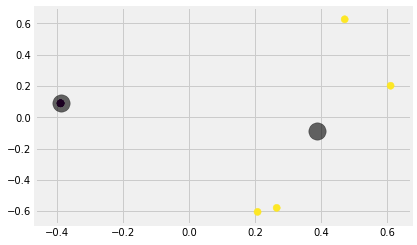

[0 1]


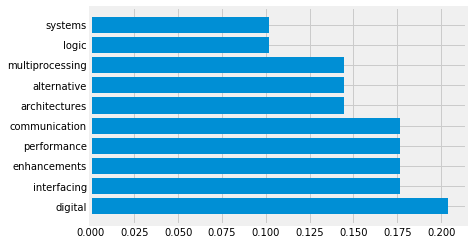

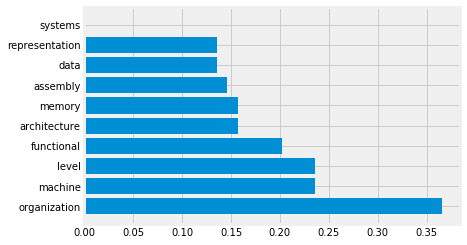

DIGITAL LOGIC AND DIGITAL SYSTEMS
Core-Tier1
Core-Tier2
--> Topic


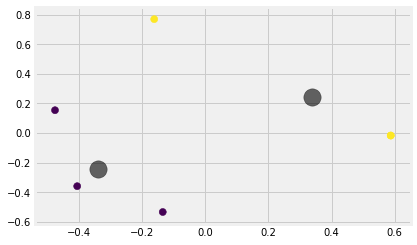

[0 1]


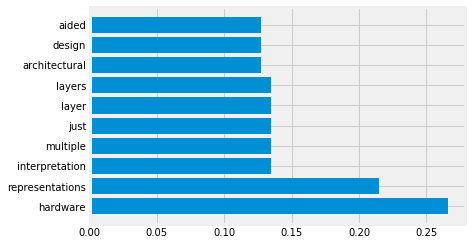

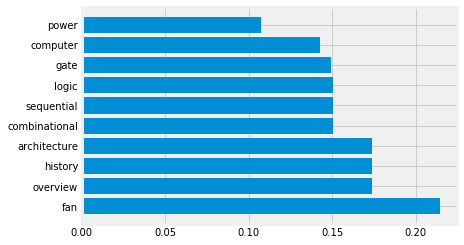

--> Leaning Outcomes


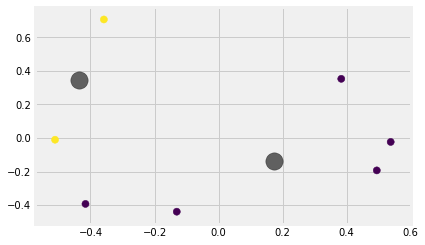

[0 1]


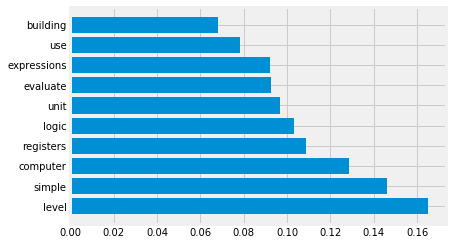

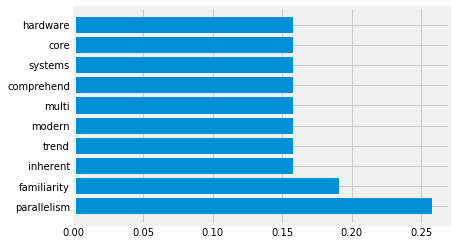

MACHINE LEVEL REPRESENTATION OF DATA
Core-Tier1
Core-Tier2
--> Topic


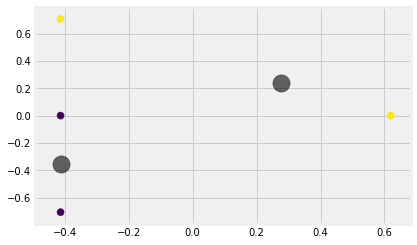

[0 1]


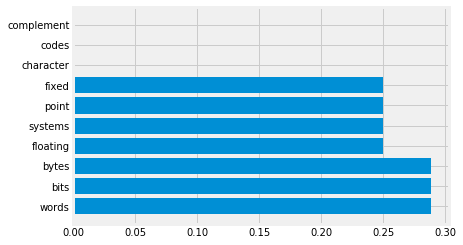

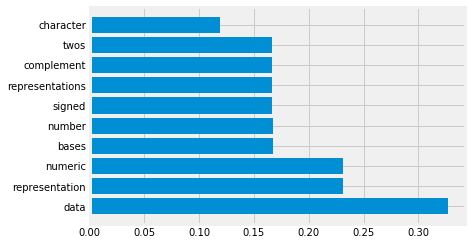

--> Leaning Outcomes


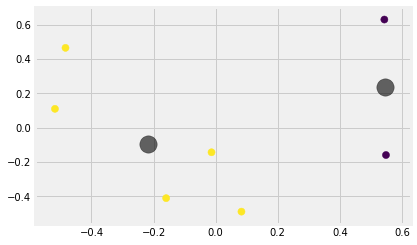

[0 1]


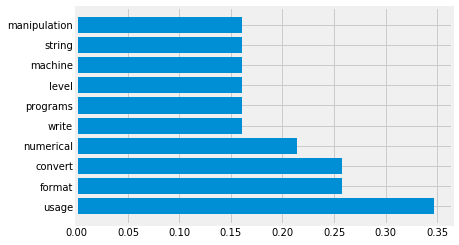

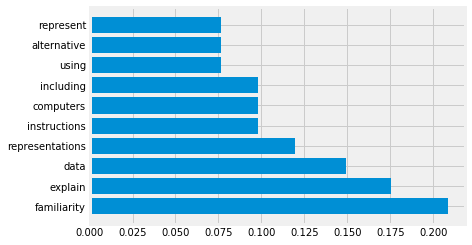

ASSEMBLY LEVEL MACHINE ORGANIZATION
MEMORY SYSTEM ORGANIZATION AND ARCHITECTURE
INTERFACING AND COMMUNICATION
FUNCTIONAL ORGANIZATION
MULTIPROCESSING AND ALTERNATIVE ARCHITECTURES
PERFORMANCE ENHANCEMENTS


In [6]:
for ka in dfka.values:
    #Proces text of description KA
    '''
    sentences = ka[3].split("\n")[1:-1]
    dfVectorizer = vectorizarDocs(sentences)
    predicted_values = draw_cluster(dfVectorizer,3)
    get_top_features_cluster(dfVectorizer, predicted_values,10)
    '''
    
    
    #Process KU of KA
    query = f"SELECT * FROM k_u where k_a_id={ka[0]}"
    dfku = pd.read_sql(query, engine)
    print('Unidades de Conocimiento: ')
    dfVectorizer = vectorizarDocs(dfku['name'])
    #dfVectorizer = vectorizarDocs(concat_str(dfku['name'],'Algorithms and Complexity'))
    predicted_values = draw_cluster(dfVectorizer,2)
    get_top_features_cluster(dfVectorizer, predicted_values,10)
    
    #iterate KU
    for ku in dfku.values:
        print(ku[1].upper())
        #Process CoreTiers: Topics,LO
        query = f"SELECT * FROM core_tier  where k_u_id={ku[0]}"
        dfcore_tier = pd.read_sql(query, engine)
        for ct in dfcore_tier.values:
            print(ct[1])
            query = f"SELECT * FROM topics where core_tier_id ={ct[0]}"
            dftopics = pd.read_sql(query, engine)
            if len(dftopics) > 0:
                print('--> Topic')
                dfVectorizer = vectorizarDocs(dftopics['name'])
                predicted_values = draw_cluster(dfVectorizer,2)
                get_top_features_cluster(dfVectorizer, predicted_values,10)

                query = f"SELECT * FROM learning_outcomes where core_tier_id ={ct[0]}"
                df_lo = pd.read_sql(query, engine)
                print('--> Leaning Outcomes')
                dfVectorizer = vectorizarDocs(df_lo['name'])
                predicted_values = draw_cluster(dfVectorizer,2)
                get_top_features_cluster(dfVectorizer, predicted_values,10)
    